In [1]:
import pandas as pd
import numpy as np
import laspy
from sklearn.metrics import precision_recall_fscore_support
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import helper
import pickle
from tqdm import tqdm
import classes, offsets

In [2]:
# Set the figure format to support high DPI
%config InlineBackend.figure_format = 'retina'

### Import, shift/flip and plot point clouds (.las)

In [3]:
# Load the real point cloud
synth_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Data Sets/Synthetic/Val_1 - Cloud - Overlap - Cut.las'
synth_pc = laspy.read(synth_pc_path)
real_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/train/Train1 - labelled - metric - cut.las'
real_pc = laspy.read(real_pc_path)

LasData
├─ header (LasHeader)
│   ├─ file_signature
│   ├─ file_source_id
│   ├─ global_encoding
│   ├─ ...
│
├─ points (LasPointRecord)
│   ├─ x
│   ├─ y
│   ├─ z
│   ├─ intensity
│   ├─ classification
│   ├─ ...
│
├─ raw_classification (optional)
├─ raw_scan_angle (optional)
├─ gps_time (optional)
├─ ...


In [4]:
# Some quick data information
helper.print_dims(real_pc)
helper.print_dims(synth_pc)

Point Cloud Min, Max, Offset:
[6.78069825e+05 5.40366865e+06 4.00265503e+02]
[6.78209878e+05 5.40383634e+06 4.45222290e+02]
[670000.0, 5400000.0, 0.0]
Point Cloud Min, Max, Offset:
[3997.00634766 1123.95703125  414.2142334 ]
[4208.37695312 1335.97583008  436.09613037]
[0.0, 0.0, 0.0]


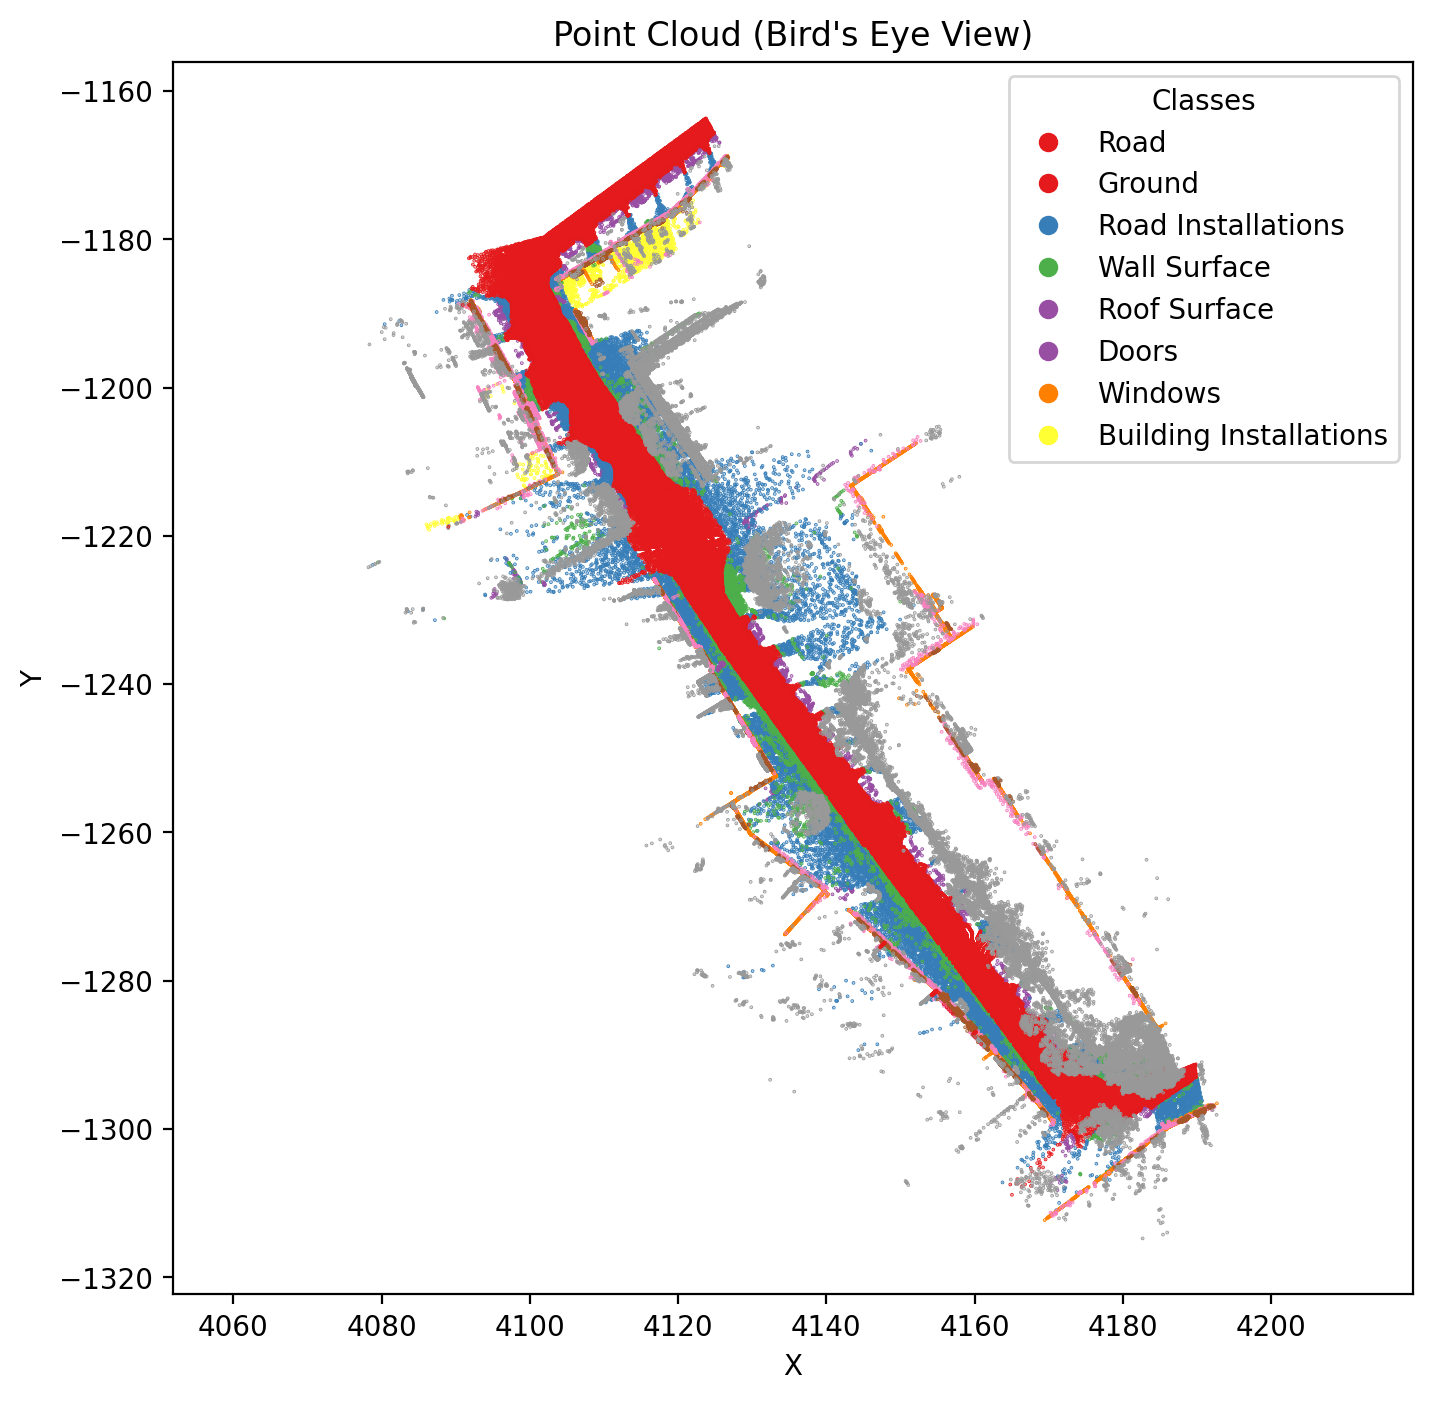

Point Cloud Min, Max, Offset:
[ 4069.82470703 -1316.51733398   400.26550293]
[ 4192.98632812 -1163.65600586   445.22229004]
[-4000.0, -5000.0, 0.0]


In [4]:
real_pc_shifted = helper.apply_offset(real_pc, x_offset=-674000, y_offset=-5405000, z_offset=0)  # Apply the offset

helper.plot_bev(real_pc_shifted, type='real')
helper.print_dims(real_pc_shifted)

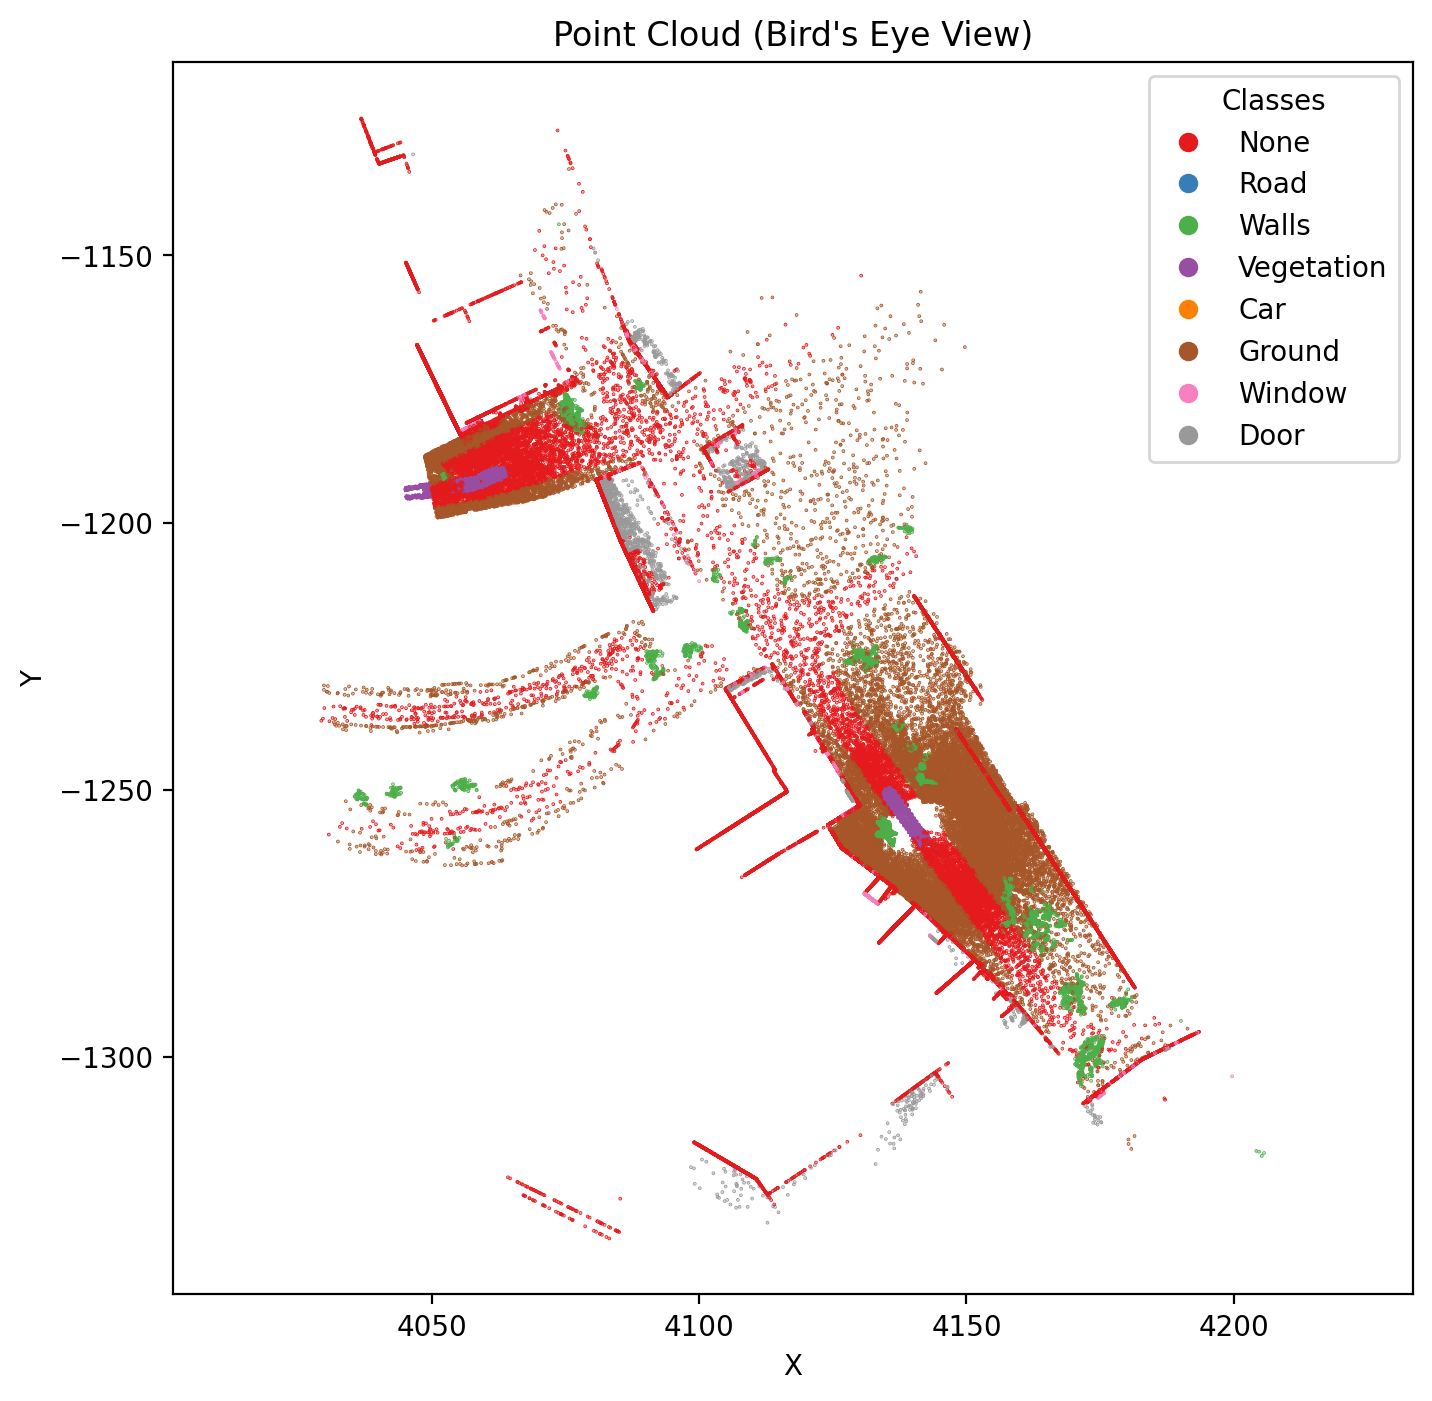

Point Cloud Min, Max, Offset:
[ 3997.00634766 -1123.95703125   414.2142334 ]
[ 4208.37695312 -1335.97583008   436.09613037]
[0.0, 0.0, 0.0]


In [6]:
synth_pc = laspy.read(synth_pc_path)
synth_pc_flipped = helper.apply_y_flip(synth_pc) 

helper.plot_bev(synth_pc_flipped.points, type='synth')
helper.print_dims(synth_pc_flipped)

### Filter & Crop Point Clouds

In [7]:
relevant_classes_real = list(classes.CLASS_DESCRIPTIONS_REAL.keys())
relevant_classes_synth = list(classes.CLASS_DESCRIPTIONS_SYNTH.keys())

In [8]:
# borders real pc
header_real = real_pc_shifted.header
min_borders_real = header_real.min
max_borders_real = header_real.max


# borders synth pc
header_synth = synth_pc_flipped.header
min_borders_synth = header_synth.min
max_borders_synth = header_synth.max


# bounding box & rectangular crop
padding = 1.0
min_xyz = np.maximum(min_borders_real, min_borders_synth) 
max_xyz = np.minimum(max_borders_real, max_borders_synth)
bounding_box = np.add(np.concatenate((min_xyz, max_xyz)), [-padding, -padding, -padding, padding, padding, padding])
cropped_points_real = helper.crop_points(real_pc_shifted.points, bounding_box)
cropped_points_synth = helper.crop_points(synth_pc_flipped.points, bounding_box)

In [10]:
print(cropped_points_real)
print(cropped_points_synth)

<ScaleAwarePointRecord(fmt: <PointFormat(0, 24 bytes of extra dims)>, len: 26878979, point size: 44)>
<ScaleAwarePointRecord(fmt: <PointFormat(0, 8 bytes of extra dims)>, len: 10892181, point size: 28)>


In [11]:
# Filter real point cloud
real_labels = cropped_points_real['classification']
relevant_indices = np.isin(real_labels, relevant_classes_real)
relevant_points_real = cropped_points_real[relevant_indices]
real_xyz = relevant_points_real[['x', 'y', 'z']]

# Filter synthetic point cloud
synth_labels = cropped_points_synth.semantic_tags
relevant_indices = np.isin(synth_labels, relevant_classes_synth)
relevant_points_synth = cropped_points_synth[relevant_indices]
synth_xyz = relevant_points_synth[['x', 'y', 'z']]

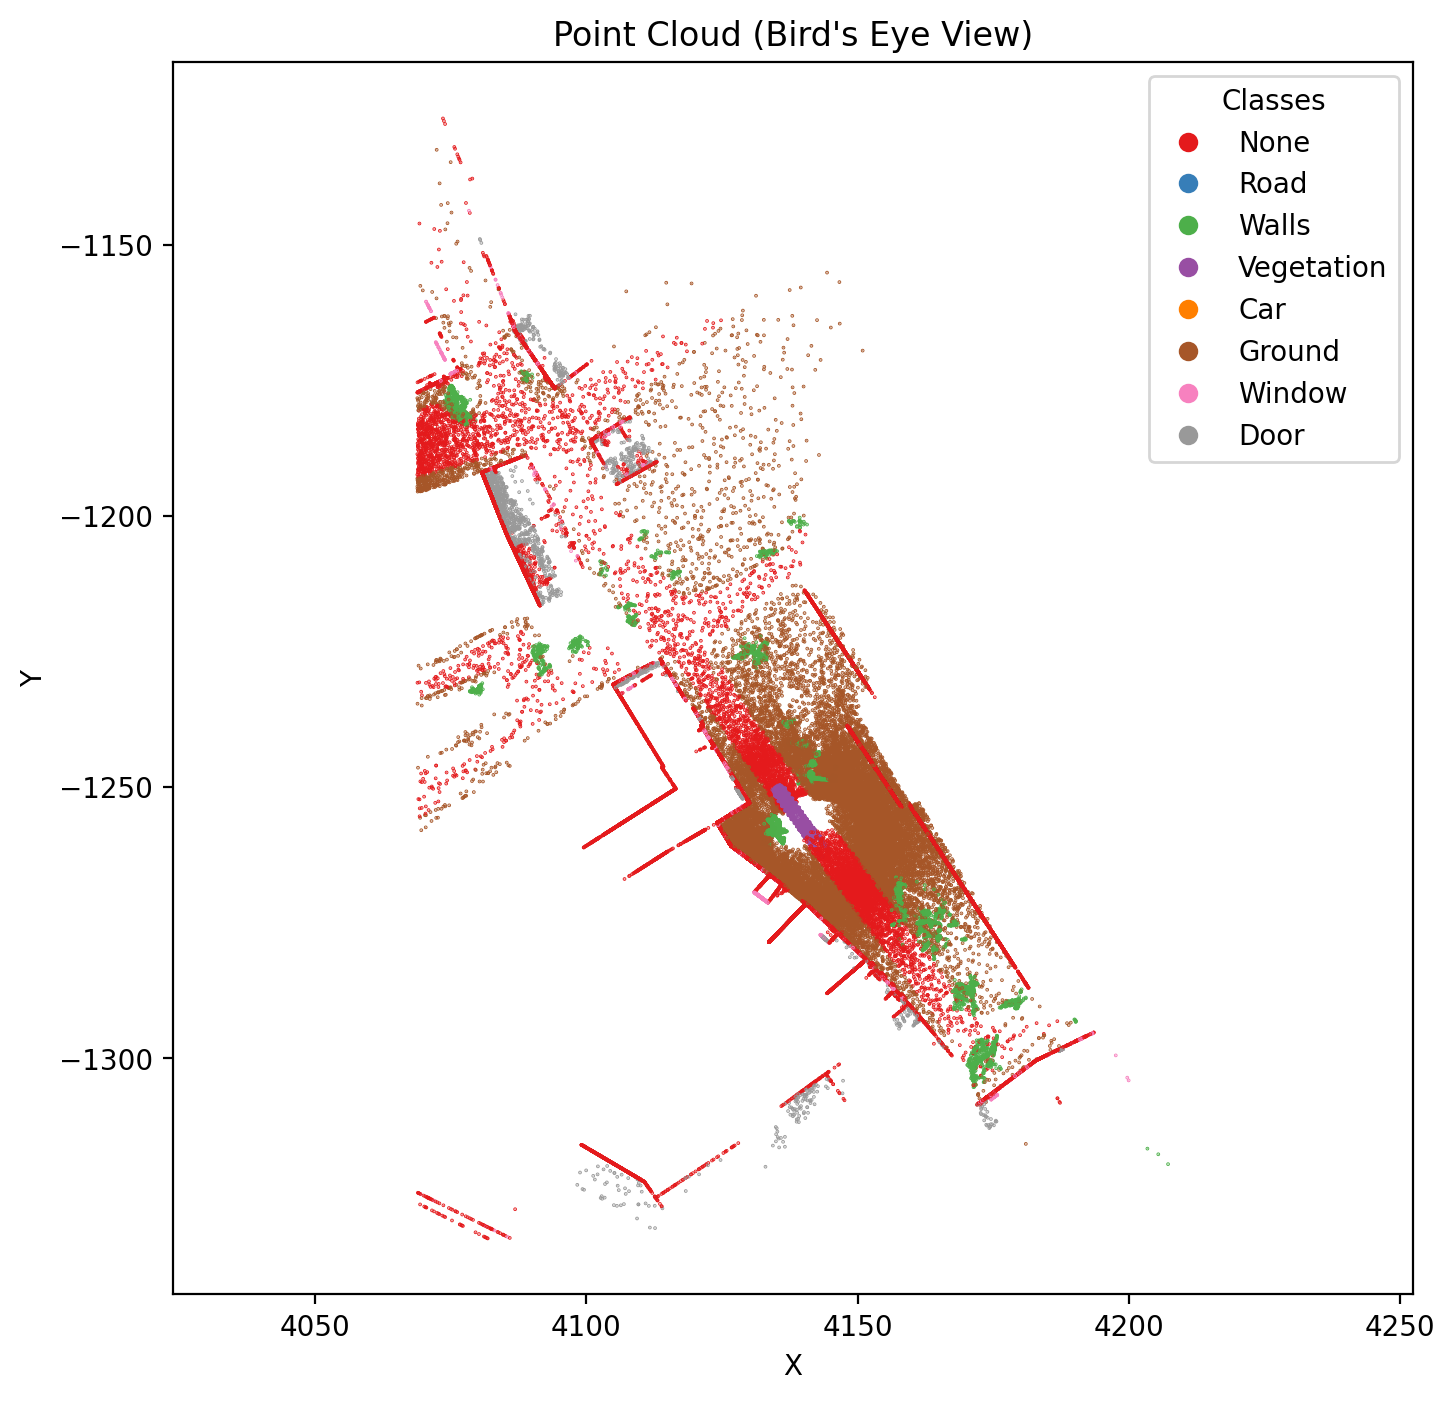

In [13]:
# proble if point cloud shifts do not match, then intersection of bounding boxes is empty and plotting crashes
# visualize synthetic point cloud
helper.plot_bev(cropped_points_synth, 'synth')

### All of the above in one helper function

In [8]:
synth_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Data Sets/Synthetic/Val_1 - Cloud - Overlap - Cut.las'
real_pc_path = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/train/Train1 - labelled - metric - cut.las'
cropped_points_real, cropped_points_synth = helper.import_and_prepare_point_clouds(real_pc_path, synth_pc_path, shift_real=True, flip_synth=True)

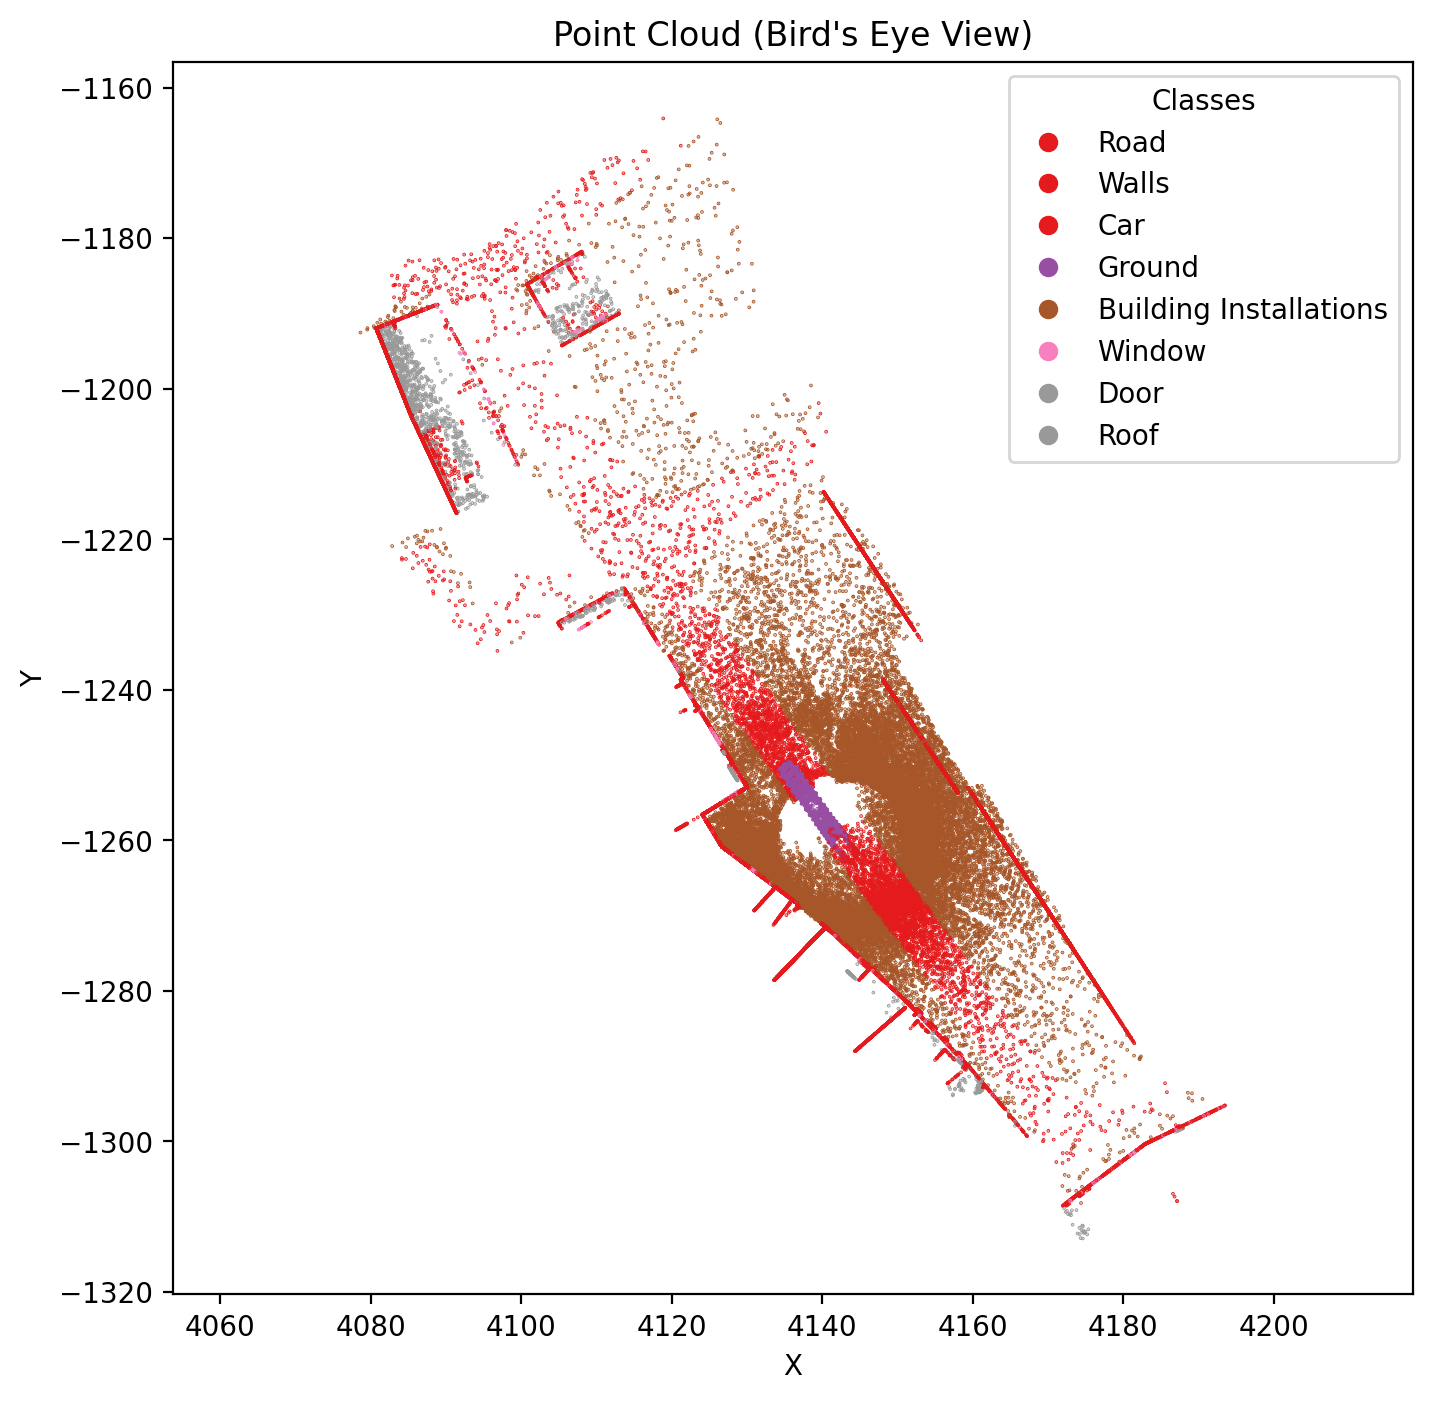

In [9]:
helper.plot_bev(cropped_points_synth, 'synth')

#### Crop Point Clouds (intersection)

In [ ]:
# TODO: Bounding Box calculation based on class-filtered points?

In [ ]:
# TODO: Use Convex hull for better cropping (intersection of two sets)?

#### Geometric Similarity (Haussdorff Distance)

In [ ]:
# extract purely the coordinates of the points
real_xyz_cropped = real_points_cropped[['x', 'y', 'z']]
synth_xyz_cropped = synth_points_cropped[['x', 'y', 'z']]
# IDEA: do haussdorff distance only for each class/label

Convex hull objects need to be computed with the script.

In [ ]:
# Load the ConvexHull object from disk
convex_hull_path_real = '/home/Meins/Uni/TUM/SS23/Data Lab/Labelling/Label-Datasets/valid/convex_hull_real.pkl'
with open(convex_hull_path_real, "rb") as file:
    loaded_convex_hull = pickle.load(file)

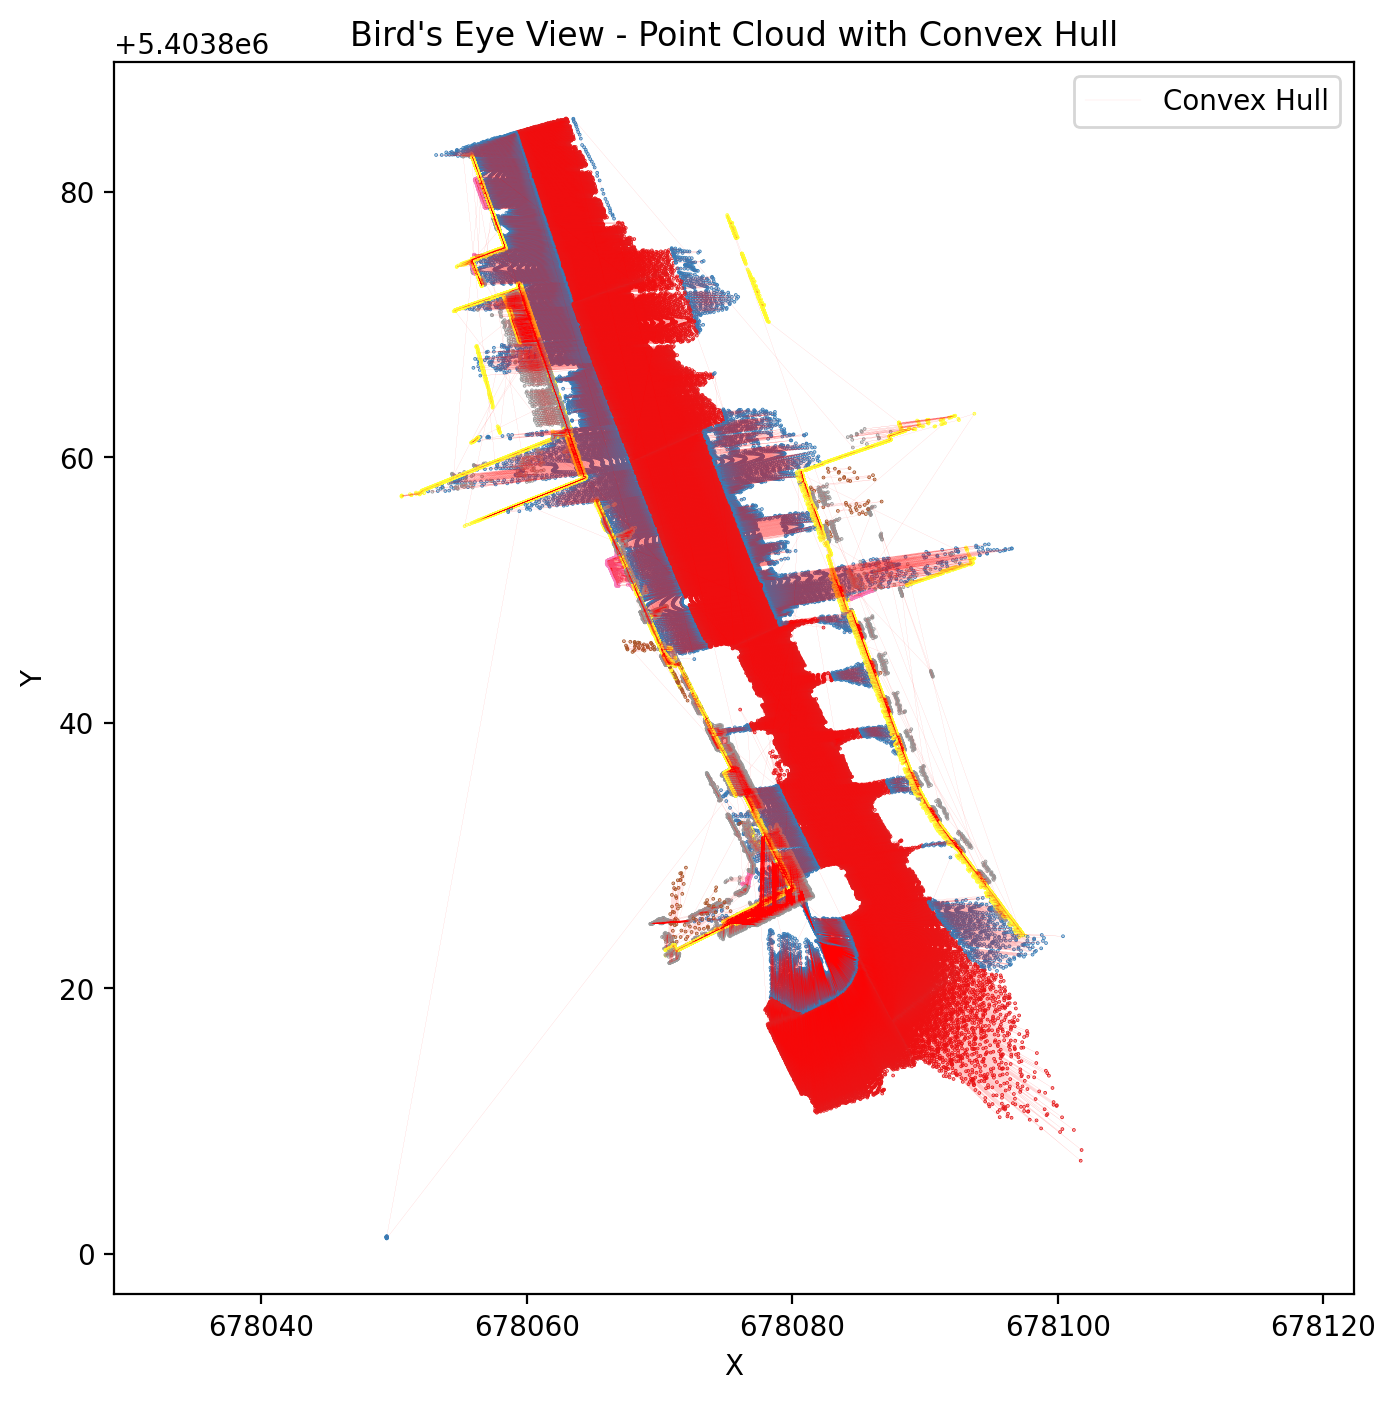

In [ ]:
# Plot Convex hull in BEV over the data points
stride = 50
x = real_points_cropped['x'][::stride]
y = real_points_cropped['y'][::stride]
labels_sampled = real_points_cropped['classification'][::stride]

# Create a scatter plot of the point cloud
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x, y, s=0.1, c=labels_sampled, cmap='Set1')

legend_colors = scatter.legend_elements(prop='colors')[0]


# Extract the x and y coordinates of the convex hull vertices
hull_vertices = loaded_convex_hull.points[:, :2]
hull_x = hull_vertices[:, 0][::stride]
hull_y = hull_vertices[:, 1][::stride]

plt.plot(hull_x, hull_y, color='red', linewidth=0.02, label='Convex Hull')
plt.legend(legend_colors, list(class_descriptions.values()), loc='upper right', title='Classes')
plt.title('Bird\'s Eye View - Point Cloud with Convex Hull')
plt.xlabel('X')
plt.ylabel('Y')
plt.axis('equal')
plt.legend()
plt.show()

In [ ]:
from scipy.spatial.distance import directed_hausdorff
def hausdorff_distance(point_set1, point_set2, hull1, hull2):

    distance1 = directed_hausdorff(point_set1, point_set2[hull2.vertices])[0]
    distance2 = directed_hausdorff(point_set2, point_set1[hull1.vertices])[0]

    return max(distance1, distance2)

In [ ]:
# TIME INTENSIVE/CRASHES KERNEL
# Compute the geometric difference between the aligned point clouds.
convex_hull_real = loaded_convex_hull
convex_hull_synth = loaded_convex_hull
#haussdorff_distance = hausdorff_distance(real_xyz_cropped, synth_xyz_cropped, convex_hull_real, convex_hull_synth)

In [ ]:
# Load the real point cloud using helper function
cropped_points_1, cropped_points_2 = helper.import_and_prepare_point_clouds(real_pc_path, synth_pc_path)
cropped_cloud_1 = pyntcloud.PyntCloud(cropped_points_1)
cropped_cloud_2 = pyntcloud.PyntCloud(cropped_points_2)

NameError: name 'pyntcloud' is not defined